In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [37]:
# Import data
df = pd.read_csv('dementia_dataset.csv')

# Remove columns not used in model
df.drop(columns = ['Subject ID', 'MRI ID', 'Hand', 'MR Delay'],inplace=True)


# Cleaning and modifying data
df_one = pd.get_dummies(df["Group"])
df_two = pd.concat((df_one, df), axis=1).drop(["Group", "Nondemented", "Converted"], axis=1)
df_three = pd.get_dummies(df_two["M/F"])
df_four = pd.concat((df_three, df_two), axis=1)
df_four = df_four.drop(['F', 'M/F'], axis=1)
data = df_four.rename(columns={"M": "Gender"})
data = data[['Gender', 'Visit', 'Age', 'EDUC', 'SES',
       'MMSE', 'eTIV', 'nWBV', 'ASF', 'Demented']]

# Replacing a few missing values with dataset mean
data['SES'] = data['SES'].fillna(np.mean(data['SES']))
data['MMSE'] = data['MMSE'].fillna(np.mean(data['MMSE']))

# Display first 5 data points
data.head()

,Gender,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,Demented
0,1,1,87,14,2.000000,27.0,1987,0.696,0.883,0
1,1,2,88,14,2.000000,30.0,2004,0.681,0.876,0
2,1,1,75,12,2.460452,23.0,1678,0.736,1.046,1
3,1,2,76,12,2.460452,28.0,1738,0.713,1.010,1
4,1,3,80,12,2.460452,22.0,1698,0.701,1.034,1


In [47]:
# Initialize LogisticRegression for model and StandardScaler for scaling data
lr = LogisticRegression()
scaler = StandardScaler()

# Features
X = data.iloc[:,:9].to_numpy()

# Label
y = data.iloc[:,-1].to_numpy().reshape(-1)

# Splitting training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=0)

Training accuracy: 0.8433734939759037
Validation accuracy: 0.8548387096774194
Coefficients: [[ 0.83208617 -0.51097476 -0.7960793  -0.38045125  0.10865931 -2.66014704
  -0.039383   -0.80090716  0.39262039]]


[Text(0, 0.5, 'non-demented'), Text(0, 1.5, 'demented')]

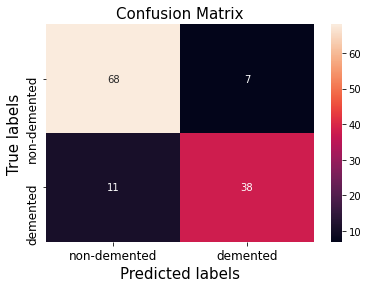

In [53]:
# Scale data with StandardScaler and fit logistic regression

lr.fit(scaler.fit_transform(X_train), y_train)
y_pred_train = lr.predict(scaler.fit_transform(X_train))
y_pred_val = lr.predict(scaler.fit_transform(X_val))
training_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)
print(f"Training accuracy: {training_acc}")
print(f"Validation accuracy: {val_acc}")
print(f"Coefficients: {lr.coef_}")

conf_mat = confusion_matrix(y_val, y_pred_val) # NOTE: please pay attention to the order of arguments, the order matters.
precision_recall_fscore_support(y_val, y_pred_val, average=None)

ax = plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)
ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)

In [13]:
# Same process but with sklearn's Pipeline

from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
pipe.fit(X_train, y_train)
train_acc_pip = pipe.score(X_train, y_train)
val_acc_pip = pipe.score(X_val, y_val)
# Print training and validation errors
print(f"Training error (pipeline): {train_acc_pip}")
print(f"Validation error (pipeline): {val_acc_pip}")

Training error (pipeline): 0.8566308243727598
Validation error (pipeline): 0.851063829787234


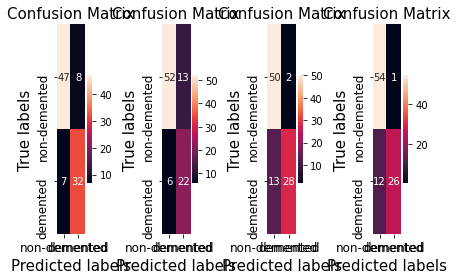

In [62]:
cv = KFold(n_splits=4, shuffle=True, random_state=42)

training_accuracy = [] # store the training errors
validation_accuracy = [] # store the validation errors

# Iterate through the indices of train and validation (iteration through each split of 10)
for i, (train_index, val_index) in enumerate(cv.split(y)):
    
    ax = plt.subplot(1, 4, i+1)

    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    lr.fit(scaler.fit_transform(X_train_cv), y_train_cv)
    y_pred_train_cv = lr.predict(scaler.fit_transform(X_train_cv))
    y_pred_val_cv = lr.predict(scaler.fit_transform(X_val_cv))
    acc_train_cv = accuracy_score(y_train_cv, y_pred_train_cv)
    acc_val_cv = accuracy_score(y_val_cv, y_pred_val_cv)
    
    
    conf_mat = confusion_matrix(y_val_cv, y_pred_val_cv) # NOTE: please pay attention to the order of arguments, the order matters.


    sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels',fontsize=15)
    ax.set_ylabel('True labels',fontsize=15)
    ax.set_title('Confusion Matrix',fontsize=15)
    ax.xaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
    ax.yaxis.set_ticklabels(['non-demented', 'demented'],fontsize=12)
    plt.tight_layout()
    
    
    # pipe.fit(X_train, y_train)
    
    # err_train_pip = pipe.score(X_train, y_train)
    # err_val_pip = pipe.score(X_val, y_val)
              
    training_accuracy.append(acc_train_cv)
    validation_accuracy.append(acc_val_cv)
    
plt.show()


In [55]:
validation_accuracy

[0.8404255319148937,
 0.7956989247311828,
 0.8387096774193549,
 0.8602150537634409]

In [56]:
training_accuracy

[0.8494623655913979,
 0.8785714285714286,
 0.8535714285714285,
 0.8535714285714285]

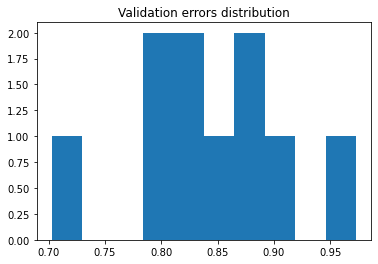

In [42]:
# Plot the distribution of the validation errors
plt.hist(validation_errors)
plt.title("Validation errors distribution")
plt.show()

In [ ]:
# test